# Implementing and Training ResNet

## Setup

In [1]:
%matplotlib inline

from __future__ import division, print_function

import os, json
from glob import glob
import numpy as np
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input, Activation, merge, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import History, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
import keras.preprocessing.image as image
from keras.utils.data_utils import get_file
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.applications.resnet50 import identity_block, conv_block

import numpy as np

import matplotlib.pyplot as plt

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


Building the ResNet model, to add the preprocessing function. 

In [2]:
def ResNet_inv():
    RN_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
    def RN_preprocess(x, RN_mean):
        RN_mean = np.asarray(RN_mean)
        x = x - RN_mean
        return x[:, ::-1] # reverse axis bgr->rgb
    
    img_input = Input(shape =(3,224,224))
    bn_axis = 1
    
    x = Lambda(RN_preprocess, arguments={'RN_mean': RN_mean.tolist()})(img_input)
    x = ZeroPadding2D((3, 3))(x)
    x = Convolution2D(64, 7, 7, subsample=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    for n in ['b','c','d']: x = identity_block(x, 3, [128, 128, 512], stage=3, block=n)
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    for n in ['b','c','d', 'e', 'f']: x = identity_block(x, 3, [256, 256, 1024], stage=4, block=n)

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    model_base = Model(img_input, x)
    
    #convert_all_kernels_in_model(model_base)
    
    wpath = model_base.load_weights(get_file(fname = 'resnet_nt.h5', 
                                             origin = 'http://files.fast.ai/models/resnet_nt.h5',
                                             cache_subdir='models'))
    y = model_base.output

    y = GlobalAveragePooling2D()(y)

    preds = Dense(2, activation = 'softmax')(y)

    ResNet = Model(input=model_base.input, output=preds)
    
    return ResNet

Now that I have this first model, let's just finetune it quickly, to see how it does.

In [3]:
ResNet = ResNet_inv()

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [ ]:
for layer in ResNet.layers[:-2]: layer.trainable = False

ResNet.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])

A note on preprocessing: 

Rather than rewriting the model to include a Lambda layer, I could just have added a preprocessing function, defining 'preprocess input' in the same way as in the model. 

I also use data augmentation, as I did in for the VGG model. 

In [4]:
batch_size = 32

train_gen = image.ImageDataGenerator(horizontal_flip = True,
                               rotation_range = 30,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                                height_shift_range = 0.1,
                                width_shift_range = 0.1, 
                               #preprocessing_function=preprocess_input
                                )


batches = train_gen.flow_from_directory("data/invasive/train", 
                                        target_size = (224, 224), 
                                        batch_size = batch_size, 
                                        )

valid_gen = image.ImageDataGenerator(#preprocessing_function = preprocess_input
                                    )

valid_batches = valid_gen.flow_from_directory("data/invasive/valid", 
                                              target_size = (224, 224), 
                                              batch_size = batch_size, 
                                              shuffle = False, 
                                             )

Found 2095 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


## First try: Only training the last layer

Let's quickly try training the model, to see how ResNet does at its base. 

In [6]:
ResHistory = History()

ResHistory = ResNet.fit_generator(generator =batches, 
                                  samples_per_epoch=batches.nb_sample, 
                                  nb_epoch = 15, 
                                  validation_data=valid_batches, 
                                  nb_val_samples=valid_batches.nb_sample, 
                                  callbacks = ([ResHistory,
                                                EarlyStopping(monitor='val_acc', patience = 3),
                                                ModelCheckpoint('/home/ubuntu/INV-RES.model',
                                                                monitor='val_acc', 
                                                                save_best_only=True)
                                               ]))

Epoch 1/15
2095/2095 [==============================] - 98s - loss: 0.6456 - acc: 0.6353 - val_loss: 0.7265 - val_acc: 0.5750
Epoch 2/15
2095/2095 [==============================] - 76s - loss: 0.4822 - acc: 0.7599 - val_loss: 0.5197 - val_acc: 0.7150
Epoch 3/15
2095/2095 [==============================] - 80s - loss: 0.4096 - acc: 0.8153 - val_loss: 0.4208 - val_acc: 0.8000
Epoch 4/15
2095/2095 [==============================] - 79s - loss: 0.3740 - acc: 0.8368 - val_loss: 0.3792 - val_acc: 0.8500
Epoch 5/15
2095/2095 [==============================] - 77s - loss: 0.3516 - acc: 0.8396 - val_loss: 0.3543 - val_acc: 0.8600
Epoch 6/15
2095/2095 [==============================] - 77s - loss: 0.3345 - acc: 0.8544 - val_loss: 0.3354 - val_acc: 0.8650
Epoch 7/15
2095/2095 [==============================] - 75s - loss: 0.3242 - acc: 0.8568 - val_loss: 0.3231 - val_acc: 0.8700
Epoch 8/15
2095/2095 [==============================] - 79s - loss: 0.3211 - acc: 0.8578 - val_loss: 0.3100 - val_acc:

<function matplotlib.pyplot.show>

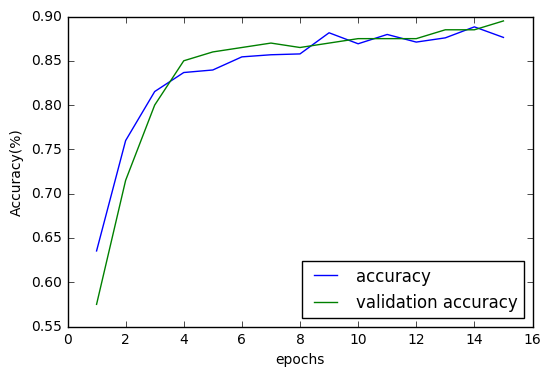

In [7]:
plt.plot(range(1, 16), ResHistory.history['acc'], label = 'accuracy')
plt.plot(range(1,16), ResHistory.history['val_acc'], label = 'validation accuracy')
plt.legend(loc = 'lower right')
plt.xlabel("epochs")
plt.ylabel("Accuracy(%)")
plt.show

Not bad for a first run! But there's defintely plenty I can do to improve. Let's try training more layers, with this as a 'base trained' model: 

In [14]:
ResNet = load_model('/home/ubuntu/invasive_ResNet_base_trained.model')

th


To try and improve this model, let's allow more layers to be trained (all the way to the last convolutional block). 

In [8]:
for layer in ResNet.layers[-7:]: layer.trainable = True

Because I am allowing more layers to be trained, I'll need to reduce the learning rate to avoid havign my model diverge. 

In [9]:
ResNet.compile(optimizer=Adam(lr=0.00001),loss='categorical_crossentropy', metrics=['accuracy'])

## Training ResNet

Okay! Let's train this model. 

In [ ]:
ResHistory1 = History()

ResHistory1 = ResNet.fit_generator(generator =batches, 
                                  samples_per_epoch=batches.nb_sample, 
                                  nb_epoch = 15, 
                                  validation_data=valid_batches, 
                                  nb_val_samples=valid_batches.nb_sample, 
                                  callbacks = ([ResHistory1,
                                                #EarlyStopping(monitor='val_acc', patience = 3),
                                                ModelCheckpoint('/home/ubuntu/INV-RES.model',
                                                                monitor='val_acc', 
                                                                save_best_only=True)
                                               ]))

Epoch 1/15
2095/2095 [==============================] - 86s - loss: 0.2554 - acc: 0.8931 - val_loss: 0.2612 - val_acc: 0.8900
Epoch 2/15
2095/2095 [==============================] - 79s - loss: 0.2641 - acc: 0.8916 - val_loss: 0.2513 - val_acc: 0.9050
Epoch 3/15
 608/2095 [=======>......................] - ETA: 35s - loss: 0.2259 - acc: 0.9079

In [19]:
acc =  ResHistory.history['acc'] +  ResHistory1.history['acc']
val_acc =  ResHistory.history['val_acc'] +  ResHistory1.history['val_acc']

<function matplotlib.pyplot.show>

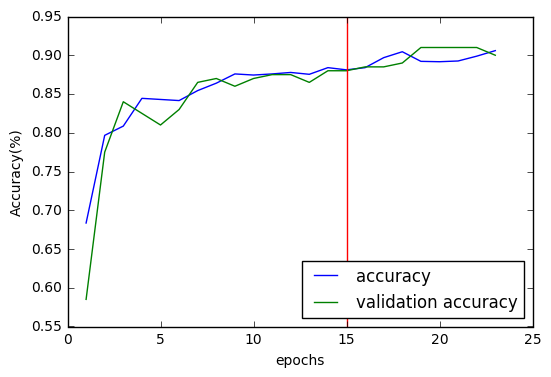

In [22]:
plt.plot(range(1, 31), acc, label = 'accuracy')
plt.plot(range(1,31), val_acc, label = 'validation accuracy')
plt.legend(loc = 'lower right')
plt.xlabel("epochs")
plt.ylabel("Accuracy(%)")
plt.axvline(x = 15, color = 'r')
plt.show

In [23]:
ResHistory2 = History()

ResHistory2 = ResNet.fit_generator(generator =batches, 
                                  samples_per_epoch=batches.nb_sample, 
                                  nb_epoch = 15, 
                                  validation_data=valid_batches, 
                                  nb_val_samples=valid_batches.nb_sample, 
                                  callbacks = ([ResHistory2,
                                                EarlyStopping(monitor='val_acc', patience = 3),
                                                ModelCheckpoint('/home/ubuntu/INV-RES.model',
                                                                monitor='val_acc', 
                                                                save_best_only=True)
                                               ]))

Epoch 1/15
2095/2095 [==============================] - 89s - loss: 0.2393 - acc: 0.8955 - val_loss: 0.2155 - val_acc: 0.9050
Epoch 2/15
2095/2095 [==============================] - 80s - loss: 0.2389 - acc: 0.8964 - val_loss: 0.2119 - val_acc: 0.9050
Epoch 3/15
2095/2095 [==============================] - 78s - loss: 0.2310 - acc: 0.9050 - val_loss: 0.2101 - val_acc: 0.9200
Epoch 4/15
2095/2095 [==============================] - 80s - loss: 0.2251 - acc: 0.9041 - val_loss: 0.2071 - val_acc: 0.9100
Epoch 5/15
2095/2095 [==============================] - 81s - loss: 0.2260 - acc: 0.9103 - val_loss: 0.2058 - val_acc: 0.9150
Epoch 6/15
2095/2095 [==============================] - 81s - loss: 0.2228 - acc: 0.9103 - val_loss: 0.2066 - val_acc: 0.9150
Epoch 7/15
2095/2095 [==============================] - 77s - loss: 0.2212 - acc: 0.9098 - val_loss: 0.2056 - val_acc: 0.9150


In [24]:
acc = acc + ResHistory2.history['acc']
val_acc = val_acc + ResHistory2.history['val_acc']

<function matplotlib.pyplot.show>

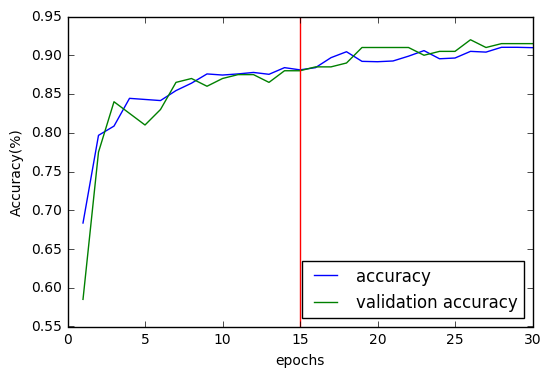

In [27]:
plt.plot(range(1, 31), acc, label = 'accuracy')
plt.plot(range(1,31), val_acc, label = 'validation accuracy')
plt.legend(loc = 'lower right')
plt.xlabel("epochs")
plt.ylabel("Accuracy(%)")
plt.axvline(x = 15, color = 'r')
plt.show